In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("All libraries imported successfully")




All libraries imported successfully


In [4]:
DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()






Dataset shape: (1458152, 28)


,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,...,g_y,g_z,subject_id,activity,pleth_3_filt,pleth_1_filt,pleth_2_filt,a_x_filt,a_y_filt,a_z_filt
0,2021-01-01 11:47:09.445505,19722,0,79526,78424,4406,85630,99618,6438,6584384,...,-0.478228,-0.710201,s12,run,-26.957562,-44.388652,-126.127361,-0.121752,0.270153,-0.227040
1,2021-01-01 11:47:09.447505,19817,0,79527,78417,4407,85630,99618,6438,6584384,...,-0.478495,-0.710867,s12,run,-25.897973,-42.984804,-122.841911,-0.145858,0.279853,-0.266853
2,2021-01-01 11:47:09.449505,19976,0,79518,78398,4405,85626,99619,6442,6584384,...,-0.476764,-0.711932,s12,run,-24.821582,-41.540573,-119.467507,-0.170565,0.297933,-0.298288
3,2021-01-01 11:47:09.451505,20136,0,79527,78410,4418,85627,99627,6444,6584384,...,-0.474367,-0.713663,s12,run,-23.728808,-40.055777,-116.004060,-0.192280,0.312419,-0.325533
4,2021-01-01 11:47:09.453505,20218,0,79527,78410,4418,85623,99610,6441,6584384,...,-0.471038,-0.715261,s12,run,-22.620070,-38.530252,-112.451508,-0.221778,0.315530,-0.362357


In [5]:
FS = 500
WINDOW_SEC = 10
WINDOW_SIZE = FS * WINDOW_SEC
STEP_SIZE = WINDOW_SIZE // 2  # 50% overlap

print("Window size:", WINDOW_SIZE)
print("Step size:", STEP_SIZE)





Window size: 5000
Step size: 2500


In [6]:
segments = []

for (subject, activity), group in df.groupby(["subject_id", "activity"]):
    group = group.reset_index(drop=True)
    green = group["pleth_3_filt"].values
    red = group["pleth_1_filt"].values
    ir = group["pleth_2_filt"].values

    for start in range(0, len(green) - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        segments.append({
            "subject_id": subject,
            "activity": activity,
            "green": green[start:end],
            "red": red[start:end],
            "ir": ir[start:end]
        })

segments_df = pd.DataFrame(segments)
print("Total PPG segments:", segments_df.shape)
segments_df.tail()





Total PPG segments: (575, 5)


,subject_id,activity,green,red,ir
570,s22,walk,"[-112.91655831704632, -112.13281098415688, -11...","[-372.27766191776766, -370.3306560426808, -368...","[-801.9207496288273, -797.5762975227566, -792...."
571,s22,walk,"[-34.88421070414923, -33.74348571193995, -32.6...","[-53.737754272596185, -51.75591692785999, -49....","[-112.1126068120572, -107.68359312749, -103.40..."
572,s22,walk,"[111.460090402011, 112.81663041221694, 114.119...","[343.935516319769, 348.2333560539387, 352.3810...","[700.828266261133, 709.4584285213338, 717.7791..."
573,s22,walk,"[72.10365319885852, 73.6364028663179, 75.16412...","[199.1551002394772, 202.9153261702699, 206.647...","[417.8672000650009, 425.7887798380801, 433.652..."
574,s22,walk,"[21.181869979042723, 21.79509942700425, 22.397...","[109.57393045696256, 111.92220866490467, 114.2...","[209.40038325525228, 213.98720091942047, 218.4..."


In [7]:
#EXTRACT HR AND SPO2 TARGETS FOR CNN (LABEL CREATION)
def calculate_spo2(red, ir):
    AC_red = np.std(red)
    DC_red = np.mean(red)
    AC_ir = np.std(ir)
    DC_ir = np.mean(ir)
    if DC_ir == 0 or AC_ir == 0:
        return np.nan
    R = (AC_red / DC_red) / (AC_ir / DC_ir)
    spo2 = 110 - 25 * R
    return np.clip(spo2, 80, 100)


def extract_hr_spo2(green, red, ir, fs=500):
    # Find peaks with min height
    peaks, _ = find_peaks(green, distance=fs * 0.5, height=np.mean(green) + 0.1 * np.std(green))
    if len(peaks) < 2:
        return None, None
    ibi = np.diff(peaks) / fs
    hr = 60 / np.mean(ibi)
    spo2 = calculate_spo2(red, ir)
    return hr, spo2





In [8]:
#APPLY TARGET EXTRACTION
hrs, spo2s, valid_segments = [], [], []

for i, row in segments_df.iterrows():
    hr, spo2 = extract_hr_spo2(row["green"], row["red"], row["ir"])
    if hr is not None and not np.isnan(spo2):
        hrs.append(hr)
        spo2s.append(spo2)
        valid_segments.append([row["green"], row["red"], row["ir"]])

X = np.array(valid_segments)  # shape (num_samples, 3, 5000)
X = np.transpose(X, (0, 2, 1))  # reshape to (num_samples, 5000, 3)
y_hr = np.array(hrs)
y_spo2 = np.array(spo2s)
print("Final samples:", X.shape)






Final samples: (575, 5000, 3)


In [9]:
#TRAIN TEST SPLIT
X_train, X_test, y_hr_train, y_hr_test, y_spo2_train, y_spo2_test = train_test_split(
    X, y_hr, y_spo2, test_size=0.3, random_state=42
)
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])






Train samples: 402 Test samples: 173


In [10]:
#NORMALIZE GLOBALLY
mean = X_train.mean(axis=(0, 1), keepdims=True)
std = X_train.std(axis=(0, 1), keepdims=True) + 1e-6
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [14]:
#1D CNN MODEL
model = Sequential([
    Conv1D(64, 7, activation="relu", input_shape=(WINDOW_SIZE, 3)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.2),

    Conv1D(128, 5, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),

    Conv1D(128, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(2)
])

model.summary()
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse")

# Show model summary
model.summary()





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4994, 64)          1408      
                                                                 
 batch_normalization_6 (Bat  (None, 4994, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 2497, 64)          0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 2497, 64)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 2493, 128)         41088     
                                                                 
 batch_normalization_7 (Bat  (None, 2493, 128)        

In [15]:
# Cell 10: Train CNN
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    np.column_stack([y_hr_train, y_spo2_train]),
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)





Epoch 1/20
11/11 [==============================] - 33s 3s/step - loss: 2028.1945 - val_loss: 7866.3672
Epoch 2/20
11/11 [==============================] - 34s 3s/step - loss: 912.1818 - val_loss: 11145.6406
Epoch 3/20
11/11 [==============================] - 30s 3s/step - loss: 588.3997 - val_loss: 14180.9287
Epoch 4/20
11/11 [==============================] - 24s 2s/step - loss: 632.9975 - val_loss: 13570.5264
Epoch 5/20
11/11 [==============================] - 27s 2s/step - loss: 633.5701 - val_loss: 12257.1152
Epoch 6/20
11/11 [==============================] - 33s 3s/step - loss: 611.3648 - val_loss: 9286.2842
Epoch 7/20
11/11 [==============================] - 31s 3s/step - loss: 643.6973 - val_loss: 5849.0728
Epoch 8/20
11/11 [==============================] - 39s 4s/step - loss: 436.0655 - val_loss: 4433.8496
Epoch 9/20
11/11 [==============================] - 40s 4s/step - loss: 579.8969 - val_loss: 2442.7634
Epoch 10/20
11/11 [==============================] - 37s 3s/step - l

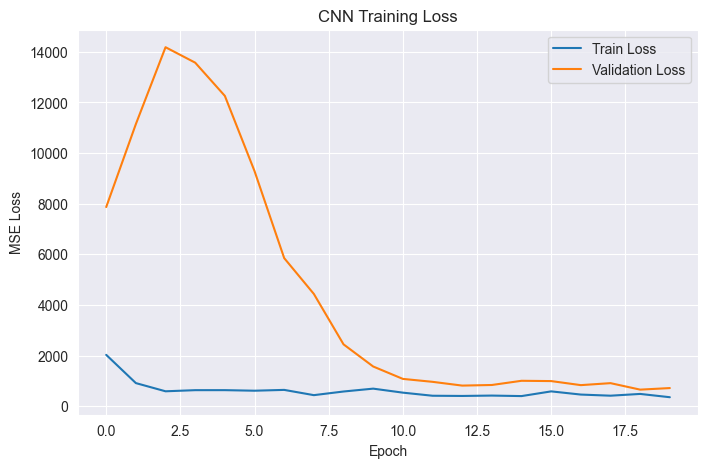

In [16]:
# Cell 11: Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN Training Loss')
plt.legend()
plt.show()





In [17]:
# Cell 12 EVALUATE MODEL
preds = model.predict(X_test)
hr_pred = preds[:, 0]
spo2_pred = preds[:, 1]

print("HR MAE:", mean_absolute_error(y_hr_test, hr_pred))
print("SpO2 MAE:", mean_absolute_error(y_spo2_test, spo2_pred))






6/6 [==============================] - 11s 299ms/step
HR MAE: 21.669201366071203
SpO2 MAE: 18.943808588462446


C:\Users\n\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


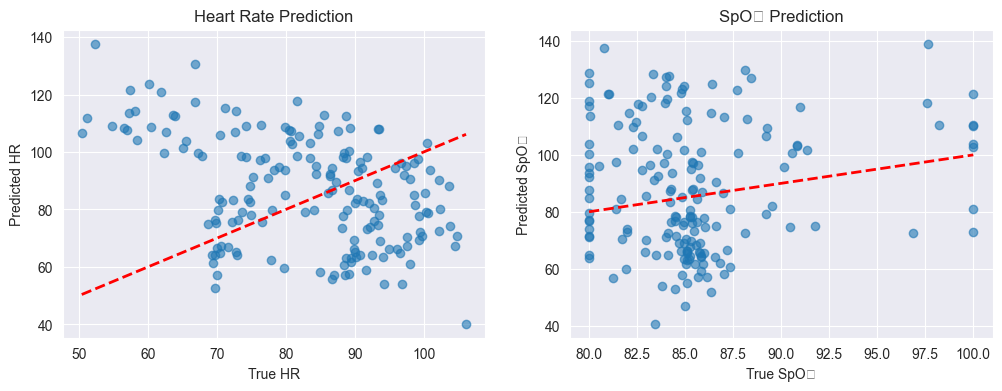

In [18]:
# Cell 13: Predictions vs true values
plt.figure(figsize=(12, 4))

# HR
plt.subplot(1, 2, 1)
plt.scatter(y_hr_test, hr_pred, alpha=0.6)
plt.plot([y_hr_test.min(), y_hr_test.max()],
         [y_hr_test.min(), y_hr_test.max()], 'r--', linewidth=2)
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("Heart Rate Prediction")

# SpO2
plt.subplot(1, 2, 2)
plt.scatter(y_spo2_test, spo2_pred, alpha=0.6)
plt.plot([y_spo2_test.min(), y_spo2_test.max()],
         [y_spo2_test.min(), y_spo2_test.max()], 'r--', linewidth=2)
plt.xlabel("True SpO₂")
plt.ylabel("Predicted SpO₂")
plt.title("SpO₂ Prediction")

plt.show()




In [1]:
# ================================
# Save Physio Prediction CNN Model
# ================================

import os

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save CNN model (Keras v3 compatible)
model.save("models/physio_cnn_model.keras", save_format="keras")

print("✅ Physio Prediction CNN model saved successfully")


NameError: name 'model' is not defined